#  Evaluation of BlueSTARR-predicted variant effects against benchmark(s)

We assess the accuracy of BlueSTARR model predictions by comparing its variant effect predictions to those generated experimentally through saturation mutagenesis via MPRA assays in [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w).

## Setup

### Imports

In [1]:
import pandas as pd
import duckdb
from pathlib import Path
import sys
sys.path.append('..')

### Paths to data and databases

In [2]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MODELS = ['K562', 'A549-DMSO']
MUT_PRED_DBs = {k: DB_ROOT / f'Kircher-2019_{k}.parquet' for k in MODELS}
DATA_DIR = PROJECT_ROOT / 'benchmarks' / 'Kircher_et_al_2019'

## Load Kircher _et al_ (2019) data files

In [3]:
from starrutil.mprautil import read_kircher_mpra_data

In [4]:
mut_data = read_kircher_mpra_data(DATA_DIR)

In [5]:
kircher_ntotal = len(mut_data.select(['chrom']).collect())
kircher_nmut = len(mut_data.select(['chrom', 'allele_pos', 'alt_allele']).unique().collect())
print(f"Total number of MPRA results: {kircher_ntotal:,}")
print(f"Total number of mutations with MPRA results: {kircher_nmut:,}")

Total number of MPRA results: 39,170
Total number of mutations with MPRA results: 29,444


## Merge with BlueSTARR mutation predictions

### BlueSTARR predictions from _in-silico_ saturated mutagenesis of Kircher _et al_ 2019 regions

In [6]:
mutpreds = {}
for model, db in MUT_PRED_DBs.items():
    mutpreds[model] = duckdb.read_parquet(str(db))
    print(f"Predictions from {model}: {mutpreds[model].count('chrom').fetchall()[0][0]:,}")

Predictions from K562: 29,532
Predictions from A549-DMSO: 29,532


### Join by chromosomal position and alternative allele

We include the reference allele as a sanity check. Including it in the join conditions in theory would be redundant with joining by chromosomal position. By omitting it from the join conditions, we can check that indeed the reference alleles are the same from both tables.

Kircher _et al_ (2019) use not only the effect size, but also the P-value and Tags columns for filtering. We therefore include both here.

In [7]:
bk_dfs = {}
for model, mutdb in mutpreds.items():
    blue_kircher = duckdb.sql(
        "select k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, "
        "m.ref_allele as blue_ref_allele, m.log2FC, "
        "last(k.Value order by abs(k.Value)) as mpra_max_log2effect, "
        "last(k.p_value order by abs(k.Value)) as mpra_p_value, "
        "last(k.Tags order by abs(k.Value)) as mpra_tags "
        "from mut_data k, mutdb m "
        "where k.chrom = m.chrom "
        "and k.allele_pos = m.allele_pos and k.alt_allele = m.allele "
        "group by k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, m.ref_allele, m.log2FC")
    bk_dfs[model] = blue_kircher.df()
    print(f"Number of MPRA results matched with BlueSTARR {model} predictions: {len(bk_dfs[model]):,} ({len(bk_dfs[model])/kircher_nmut:.1%})")


Number of MPRA results matched with BlueSTARR K562 predictions: 29,444 (100.0%)
Number of MPRA results matched with BlueSTARR A549-DMSO predictions: 29,444 (100.0%)


Sanity check: for every position, the reference alleles between Kircher _et al_ and BlueSTARR should be the same.

In [8]:
for model, bk_df in bk_dfs.items():
    ref_mismatched = bk_df.loc[bk_df['ref_allele'] != bk_df['blue_ref_allele']]
    print(f"Ref allele mismatches for {model}: {len(ref_mismatched):,}")

Ref allele mismatches for K562: 0
Ref allele mismatches for A549-DMSO: 0


## ROC display and AUC

### Define positive and negative classes

Kircher _et al_ (2019) calculate a p-value based on a linear regression model, and label positives (mutations having a significant effect) based on a p-value cut-off (p<1e-5). For the negative class (mutations without a significant effect) a cut-off on absolute effect size (at 0.05) is used. (Strictly speaking, Kircher _et al_ only give _"$log_2$ expression effect < 0.05"_, but we assume they meant _absolute_ expression effect.)

Additionally, labeling classes (as either a positive or a negative) requires a minimum Tag count. We use 10 as recommended in Kircher _et al_ (2019).

Kircher _et al_ (2019) don't explicitly mention whether there is a p-value cutoff as well for the negative class. We'll use a value that is several orders of magnitude higher than the maximum p-value for positives, but still quite low.

Note that this approach will leave some mutations unlabeled (those with low Tag count, and those with p-values in the "grey zone" between the two cut-offs).

In [9]:
from starrutil.mprautil import add_class_labels

In [10]:
Pval_pos = 1e-5
Pval_neg = 0.01
effect_neg = 0.05
pos_label = f"MPRA p≤{Pval_pos}"
neg_label = f"MPRA p>{Pval_neg}"

In [11]:
bk_dfs = {
    model: add_class_labels(bk_df,
                            Pval_pos=Pval_pos,
                            Pval_neg=Pval_neg,
                            abs_effect_neg=effect_neg,
                            pos_label=pos_label, neg_label=neg_label).dropna(subset=['label'])
    for model, bk_df in bk_dfs.items()
}
bk_df = pd.concat(bk_dfs.values(), keys=bk_dfs.keys(), names=['model'])

### Subset predictions into those with positive and negative effects

We also create a set of all effects (regardless of direction) suitable for ROC analysis, which means we use the absolute predicted effect in $\log_2$ space.

In [12]:
bk_df_pos = bk_df.loc[bk_df['mpra_max_log2effect'] >= 0]
bk_df_neg = bk_df.loc[bk_df['mpra_max_log2effect'] < 0]
bk_df['abs_log2FC'] = bk_df['log2FC'].abs()

How many positives and negatives do we have?

In [13]:
bk_df_pos.groupby(['model', 'label'])['chrom'].count()

model      label       
A549-DMSO  MPRA p>0.01     5790
           MPRA p≤1e-05    1805
K562       MPRA p>0.01     5790
           MPRA p≤1e-05    1805
Name: chrom, dtype: int64

In [14]:
bk_df_neg.groupby(['model', 'label'])['chrom'].count()

model      label       
A549-DMSO  MPRA p>0.01     4668
           MPRA p≤1e-05    2954
K562       MPRA p>0.01     4668
           MPRA p≤1e-05    2954
Name: chrom, dtype: int64

In [15]:
bk_df.groupby(['model', 'label'])['chrom'].count()

model      label       
A549-DMSO  MPRA p>0.01     10458
           MPRA p≤1e-05     4759
K562       MPRA p>0.01     10458
           MPRA p≤1e-05     4759
Name: chrom, dtype: int64

### Visualize BlueSTARR predictions versus MPRA effect size

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

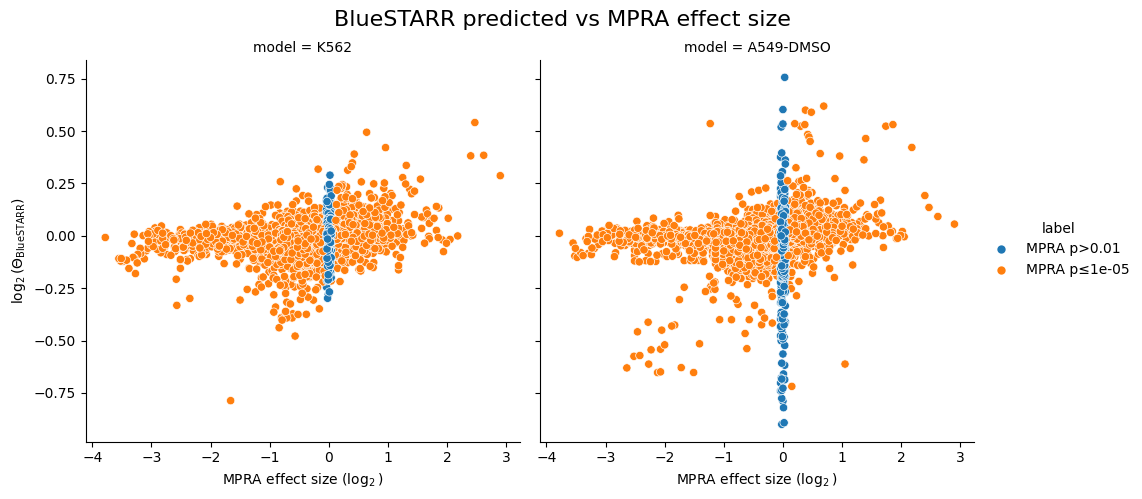

In [17]:
g = sns.relplot(data=bk_df, x='mpra_max_log2effect', y='log2FC',
                 hue='label', col='model', kind='scatter')
g.set_axis_labels('MPRA effect size ($\log_2)$', '$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
g.figure.suptitle('BlueSTARR predicted vs MPRA effect size', fontsize=16)
g.figure.subplots_adjust(top=0.88)

### ROC curve display and AUC calculation


In [18]:
from sklearn.metrics import RocCurveDisplay

Text(0.5, 0.98, 'BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)')

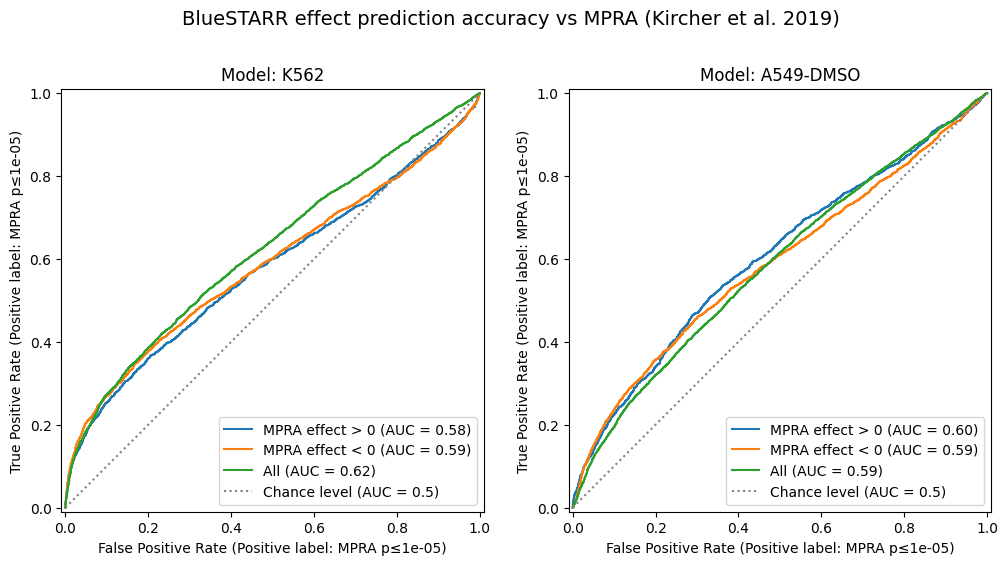

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, model in enumerate(bk_dfs.keys()):
    df_pos = bk_df_pos.xs(model, level='model')
    df_neg = bk_df_neg.xs(model, level='model')
    df_all = bk_df.xs(model, level='model')
    roc_pos = RocCurveDisplay.from_predictions(
        df_pos['label'],
        df_pos['log2FC'], pos_label=pos_label,
        name='MPRA effect > 0', ax=axs[i])
    roc_neg = RocCurveDisplay.from_predictions(
        df_neg['label'],
        -df_neg['log2FC'], pos_label=pos_label,
        name='MPRA effect < 0', ax=axs[i])
    roc_all = RocCurveDisplay.from_predictions(
        df_all['label'],
        df_all['log2FC'].abs(), pos_label=pos_label,
        name='All', ax=axs[i],
        plot_chance_level=True, chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'})
    axs[i].set_title(f'Model: {model}')
fig.suptitle('BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)', fontsize=14)


#### ROC curve and AUROC as per Kircher _et al_ (2019)

Kircher _et al_ in Supplementary Table 17 give AUC scores for a variety of classifiers, but in addition to the filtering (Tags >= 10; P<1e-5 for TPs; P>1e-5 and $\log_2$(expression effect) < 0.05 for TNs) their ROC computation uses only the top _N_, with $N \in \{200, 500, 1000\}$, variants with "highest expression effect", which we assume to be the absolute expression effect size in $\log_2$ space.

We repeat this way of subsetting the data here, too.

In [20]:
from starrutil.roc import roc_topN

In [21]:
def plot_rocs(df, models, neg_label):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for i, model in enumerate(models):
        print(f"Model: {model}")
        _, ax = roc_topN(df.xs(model, level='model'), neg_label=neg_label, pos_label=pos_label, ax=axs[i])
        ax.set_title(f'Model: {model}')
    return fig, axs

##### All regions together

Model: K562
  AUCs:
    All data = 0.622
    Top 1000 = 0.673
    Top  500 = 0.663
    Top  200 = 0.662
Model: A549-DMSO
  AUCs:
    All data = 0.585
    Top 1000 = 0.603
    Top  500 = 0.612
    Top  200 = 0.579


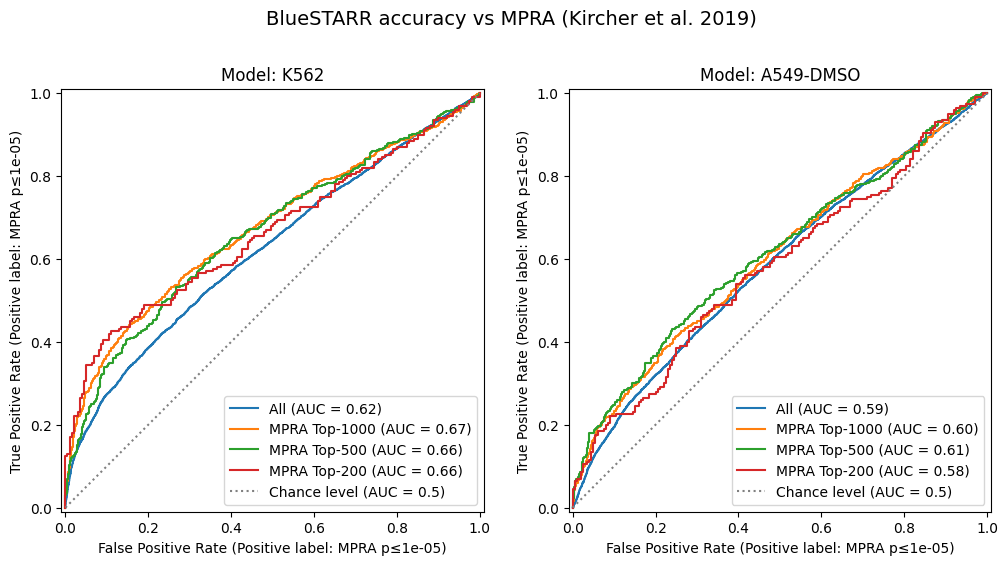

In [22]:
fig, _ = plot_rocs(bk_df, bk_dfs.keys(), neg_label)
_ = fig.suptitle('BlueSTARR accuracy vs MPRA (Kircher et al. 2019)', fontsize=14)


##### Enhancer and Promoter regions separated

Model: K562
  AUCs:
    All data = 0.588
    Top 1000 = 0.626
    Top  500 = 0.637
    Top  200 = 0.606
Model: A549-DMSO
  AUCs:
    All data = 0.598
    Top 1000 = 0.637
    Top  500 = 0.655
    Top  200 = 0.701


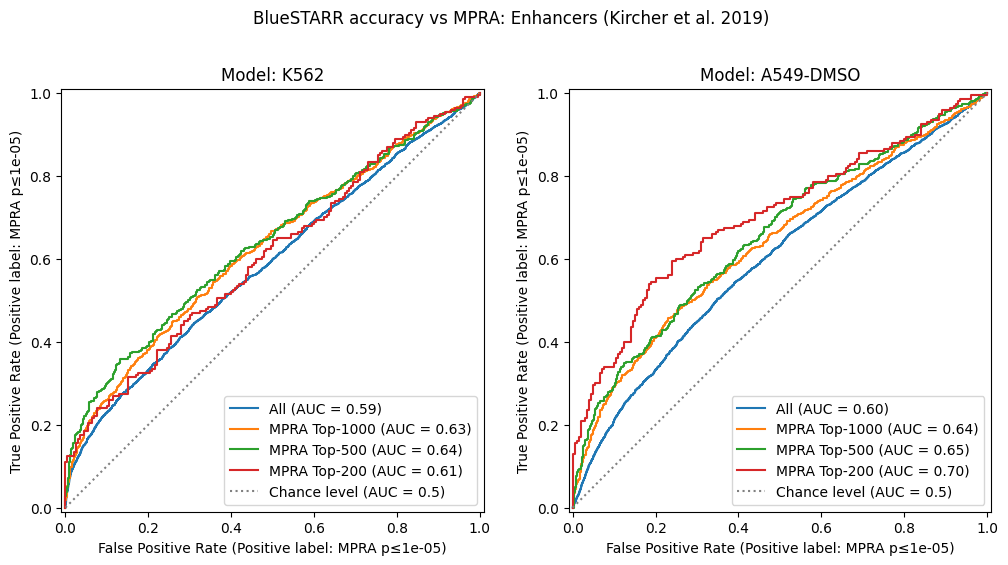

In [23]:
enh_df = bk_df.loc[bk_df['region_type'] == 'Enhancers']
fig, ax = plot_rocs(enh_df, bk_dfs.keys(), neg_label)
_ = fig.suptitle('BlueSTARR accuracy vs MPRA: Enhancers (Kircher et al. 2019)')

Model: K562
  AUCs:
    All data = 0.663
    Top 1000 = 0.718
    Top  500 = 0.712
    Top  200 = 0.724
Model: A549-DMSO
  AUCs:
    All data = 0.556
    Top 1000 = 0.562
    Top  500 = 0.523
    Top  200 = 0.471


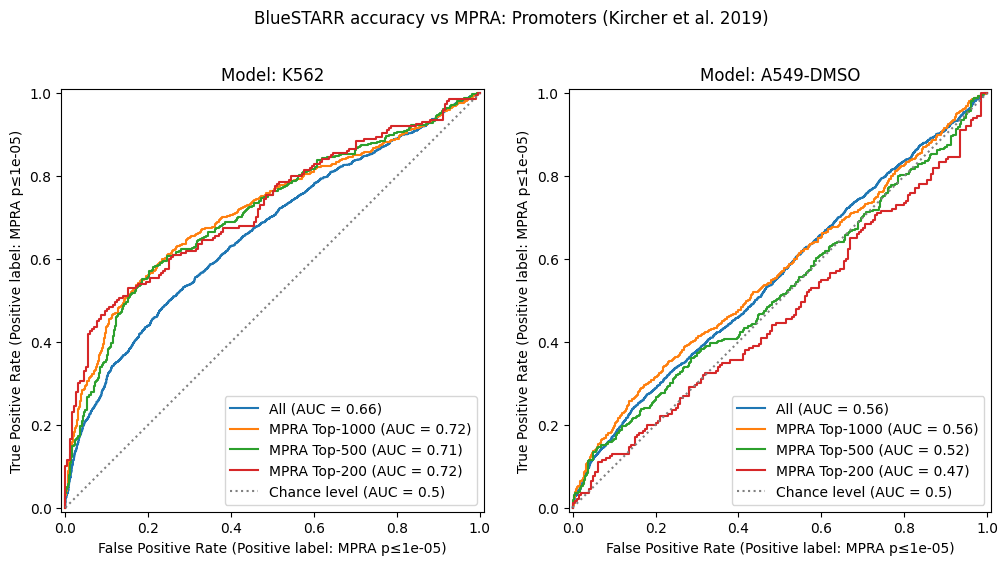

In [24]:
prom_df = bk_df.loc[bk_df['region_type'] == 'Promoters']
fig, ax = plot_rocs(prom_df, bk_dfs.keys(), neg_label)
_ = fig.suptitle('BlueSTARR accuracy vs MPRA: Promoters (Kircher et al. 2019)')